In [1]:
#initialization
import matplotlib.pyplot as plt
import numpy as np

# importing Qiskit
from qiskit import IBMQ, Aer, assemble, transpile
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.providers.ibmq import least_busy

# import basic plot tools
from qiskit.visualization import plot_histogram
from qiskit_textbook.problems import grover_problem_oracle

In [2]:
def initialize_s(qc, qubits):
    """Apply a H-gate to 'qubits' in qc"""
    for q in qubits:
        qc.h(q)
    return qc

In [3]:
def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    # Do multi-controlled-Z gate
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    qc.h(nqubits-1)
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    # We will return the diffuser as a gate
    U_s = qc.to_gate()
    U_s.name = "U$_s$"
    return U_s

# 1. grover_problem_oracle(4, variant=2) uses 4 qubits and has 1 solution.

**a) How many iterations do we need to have a > 90% chance of measuring this solution?**

In [4]:
n = 4
qc = QuantumCircuit(n)
oracle1 = grover_problem_oracle(4, variant=2, print_solutions=True)
qc = initialize_s(qc, [0,1,2,3])
# we run two iterations here
qc.append(oracle1, [0,1,2,3])
qc.append(diffuser(n), [0,1,2,3])
qc.append(oracle1, [0,1,2,3])
qc.append(diffuser(n), [0,1,2,3])
qc.measure_all()
qc.draw()

Solutions:
|0011>


┌───┐┌────────────────────┐┌────────┐┌────────────────────┐┌────────┐»
   q_0: ┤ H ├┤0                   ├┤0       ├┤0                   ├┤0       ├»
        ├───┤│                    ││        ││                    ││        │»
   q_1: ┤ H ├┤1                   ├┤1       ├┤1                   ├┤1       ├»
        ├───┤│  Oracle
n=4, var=2 ││  U$_s$ ││  Oracle
n=4, var=2 ││  U$_s$ │»
   q_2: ┤ H ├┤2                   ├┤2       ├┤2                   ├┤2       ├»
        ├───┤│                    ││        ││                    ││        │»
   q_3: ┤ H ├┤3                   ├┤3       ├┤3                   ├┤3       ├»
        └───┘└────────────────────┘└────────┘└────────────────────┘└────────┘»
meas: 4/═════════════════════════════════════════════════════════════════════»
                                                                             »
«         ░ ┌─┐         
«   q_0: ─░─┤M├─────────
«         ░ └╥┘┌─┐      
«   q_1: ─░──╫─┤M├──────
«         ░  ║ └╥┘┌─┐   
«   q_2: ─░──╫──╫─┤M├───
«         ░  ║  ║ └╥┘┌─┐
«   q_3: ─░──╫──╫──╫─┤M├
«         ░  ║  ║  ║ └╥┘
«meas: 4/════╩══╩══╩══╩═
«            0  1  2  3

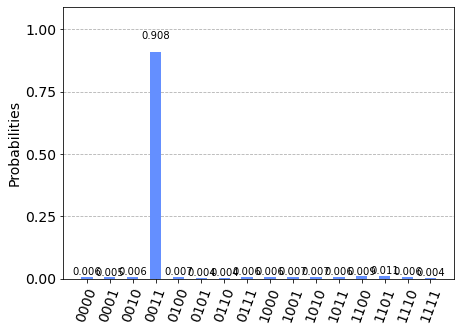

In [5]:
aer_sim = Aer.get_backend('aer_simulator')
transpiled_qc = transpile(qc, aer_sim)
qobj = assemble(transpiled_qc)
results = aer_sim.run(qobj).result()
counts = results.get_counts()
plot_histogram(counts)

Here we can observe, after 2 iterations we have a 90% chance of measuring the solution state |0011>.

**b) Use Grover's algorithm to find this solution state. c. What happens if we apply more iterations the number we calculated in problem 1a above?Why?**

The solution state we can see is |0011> which is also verified below by the oracle. If we apply more iterations we get a higher chance of calculating the correct solution as the amplitude of non-marked states decerase after each iteration and the amplitude of correct solution increases.

In [6]:
# Verification of Solution
n = 4
oracle = grover_problem_oracle(n, variant=2, print_solutions = True)  # 0th variant of oracle, with n qubits
qc = QuantumCircuit(n)
qc.append(oracle, [0,1,2,3])


Solutions:
|0011>


# 2. With 2 solutions and 4 qubits, how many iterations do we need for a >90% chance of measuring a solution? Test your answer using the oracle grover_problem_oracle(4, variant=1) (which has two solutions)

In [23]:
n = 4
qc = QuantumCircuit(n)
oracle = grover_problem_oracle(4, variant=1, print_solutions=True)
qc = initialize_s(qc, [0,1,2,3])
# we run two iterations here
qc.append(oracle, [0,1,2,3])
qc.append(diffuser(n), [0,1,2,3])
qc.measure_all()
qc.draw()

Solutions:
|0111>
|1001>


┌───┐┌────────────────────┐┌────────┐ ░ ┌─┐         
   q_0: ┤ H ├┤0                   ├┤0       ├─░─┤M├─────────
        ├───┤│                    ││        │ ░ └╥┘┌─┐      
   q_1: ┤ H ├┤1                   ├┤1       ├─░──╫─┤M├──────
        ├───┤│  Oracle
n=4, var=1 ││  U$_s$ │ ░  ║ └╥┘┌─┐   
   q_2: ┤ H ├┤2                   ├┤2       ├─░──╫──╫─┤M├───
        ├───┤│                    ││        │ ░  ║  ║ └╥┘┌─┐
   q_3: ┤ H ├┤3                   ├┤3       ├─░──╫──╫──╫─┤M├
        └───┘└────────────────────┘└────────┘ ░  ║  ║  ║ └╥┘
meas: 4/═════════════════════════════════════════╩══╩══╩══╩═
                                                 0  1  2  3

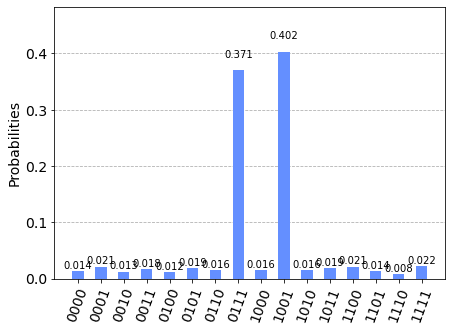

In [24]:
aer_sim = Aer.get_backend('aer_simulator')
transpiled_qc = transpile(qc, aer_sim)
qobj = assemble(transpiled_qc)
results = aer_sim.run(qobj).result()
counts = results.get_counts()
plot_histogram(counts)

**If we take one iteration then we have a 0.371+0.402 = 0.773 that is around 77% of getting the solutions**

In [25]:
n = 4
qc = QuantumCircuit(n)
oracle = grover_problem_oracle(4, variant=1, print_solutions=True)
qc = initialize_s(qc, [0,1,2,3])
# we run two iterations here
qc.append(oracle, [0,1,2,3])
qc.append(diffuser(n), [0,1,2,3])
qc.append(oracle, [0,1,2,3])
qc.append(diffuser(n), [0,1,2,3])
qc.measure_all()
qc.draw()

Solutions:
|0111>
|1001>


┌───┐┌────────────────────┐┌────────┐┌────────────────────┐┌────────┐»
   q_0: ┤ H ├┤0                   ├┤0       ├┤0                   ├┤0       ├»
        ├───┤│                    ││        ││                    ││        │»
   q_1: ┤ H ├┤1                   ├┤1       ├┤1                   ├┤1       ├»
        ├───┤│  Oracle
n=4, var=1 ││  U$_s$ ││  Oracle
n=4, var=1 ││  U$_s$ │»
   q_2: ┤ H ├┤2                   ├┤2       ├┤2                   ├┤2       ├»
        ├───┤│                    ││        ││                    ││        │»
   q_3: ┤ H ├┤3                   ├┤3       ├┤3                   ├┤3       ├»
        └───┘└────────────────────┘└────────┘└────────────────────┘└────────┘»
meas: 4/═════════════════════════════════════════════════════════════════════»
                                                                             »
«         ░ ┌─┐         
«   q_0: ─░─┤M├─────────
«         ░ └╥┘┌─┐      
«   q_1: ─░──╫─┤M├──────
«         ░  ║ └╥┘┌─┐   
«   q_2: ─░──╫──╫─┤M├───
«         ░  ║  ║ └╥┘┌─┐
«   q_3: ─░──╫──╫──╫─┤M├
«         ░  ║  ║  ║ └╥┘
«meas: 4/════╩══╩══╩══╩═
«            0  1  2  3

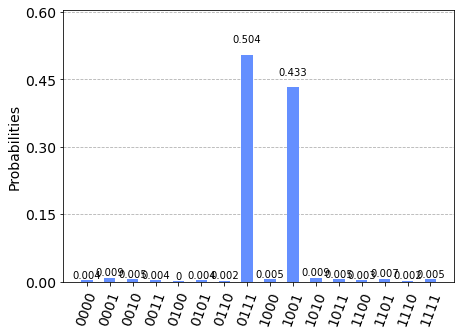

In [26]:
aer_sim = Aer.get_backend('aer_simulator')
transpiled_qc = transpile(qc, aer_sim)
qobj = assemble(transpiled_qc)
results = aer_sim.run(qobj).result()
counts = results.get_counts()
plot_histogram(counts)

**If we take two iteration then we have a 0.504+0.433 = 0.937 that is >90% chance of getting the solutions**

# 3

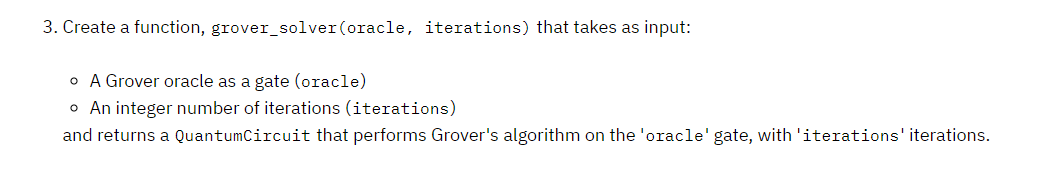

In [74]:
# define the number of qubits needed n
# define your own oracle and the nummber of iterations you need
# this code makes use of just the diffuser function

def grover_oracle(oracle, iterations):
    # applying h gates 
    for i in range(n):
        qc.h(i)
    #applying the oracle specified
    a = []
    for i in range(n):
        a.append(i)
    
    for i in range(iterations):
        qc.append(oracle, a)
        qc.append(diffuser(n), a)
    
    qc.measure_all()
    return qc

**Testing**

In [75]:
n = 4
iterations = 2
oracle = grover_problem_oracle(n, variant=1, print_solutions=True)

qc = QuantumCircuit(n, n)
qc = grover_oracle(oracle, iterations)
qc.draw()

Solutions:
|0111>
|1001>


┌───┐┌────────────────────┐┌────────┐┌────────────────────┐┌────────┐»
   q_0: ┤ H ├┤0                   ├┤0       ├┤0                   ├┤0       ├»
        ├───┤│                    ││        ││                    ││        │»
   q_1: ┤ H ├┤1                   ├┤1       ├┤1                   ├┤1       ├»
        ├───┤│  Oracle
n=4, var=1 ││  U$_s$ ││  Oracle
n=4, var=1 ││  U$_s$ │»
   q_2: ┤ H ├┤2                   ├┤2       ├┤2                   ├┤2       ├»
        ├───┤│                    ││        ││                    ││        │»
   q_3: ┤ H ├┤3                   ├┤3       ├┤3                   ├┤3       ├»
        └───┘└────────────────────┘└────────┘└────────────────────┘└────────┘»
   c: 4/═════════════════════════════════════════════════════════════════════»
                                                                             »
meas: 4/═════════════════════════════════════════════════════════════════════»
                                                                             »
«         ░ ┌─┐         
«   q_0: ─░─┤M├─────────
«         ░ └╥┘┌─┐      
«   q_1: ─░──╫─┤M├──────
«         ░  ║ └╥┘┌─┐   
«   q_2: ─░──╫──╫─┤M├───
«         ░  ║  ║ └╥┘┌─┐
«   q_3: ─░──╫──╫──╫─┤M├
«         ░  ║  ║  ║ └╥┘
«   c: 4/════╬══╬══╬══╬═
«            ║  ║  ║  ║ 
«meas: 4/════╩══╩══╩══╩═
«            0  1  2  3